In [1]:
import pandas as pd

In [2]:
df=pd.read_csv(r"C:\Users\19189\Desktop\mordred_descriptors.csv")
df

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,68523-18-2,460.00,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,0.0,0.0,0,0,34.992970,2.613976,...,10.344674,84.588084,416.069448,9.044988,2244,39,146.0,172.0,10.201389,6.166667
1,88-04-0,3830.00,CC1C=C(O)C=C(C)C=1Cl,3.583199,0.0,0.0,0,0,11.643052,2.307250,...,9.078065,39.748909,156.034193,8.212326,110,13,48.0,54.0,4.944444,2.222222
2,603-50-9,4305.00,CC(=O)OC1C=CC(=CC=1)C(C1C=CC=CN=1)C1C=CC(=CC=1...,3.633973,0.0,0.0,0,0,34.387058,2.415622,...,10.045811,61.772145,361.131408,7.850683,1954,39,136.0,155.0,8.638889,6.000000
3,120-36-5,689.00,CC(OC1C=CC(Cl)=CC=1Cl)C(O)=O,2.838219,0.0,0.0,1,0,16.532794,2.301365,...,9.254262,45.062973,233.985049,10.635684,316,18,66.0,73.0,6.555556,3.138889
4,103-26-4,2610.00,COC(=O)C=CC1C=CC=CC=1,3.416641,0.0,0.0,0,0,15.354433,2.172565,...,8.688622,41.277218,162.068080,7.366731,226,12,52.0,55.0,4.222222,2.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11982,996-04-3,1.78,CP(=O)(SCCC)SCCC,0.250420,0.0,0.0,0,0,12.592066,2.188901,...,8.586906,39.549123,212.045844,7.573066,180,10,44.0,44.0,5.562500,2.750000
11983,996-05-4,18.00,CP(=S)(SCCC)SCCC,1.255273,0.0,0.0,0,0,12.592066,2.188901,...,8.586906,39.549123,228.023000,8.143679,180,10,44.0,44.0,5.562500,2.750000
11984,99784-08-4,7500.00,COC1C=CC(=CC=1O)C1COC2=CC=CC=C2O1,3.875061,0.0,0.0,0,0,25.276144,2.403626,...,9.883948,52.530255,258.089209,7.820885,720,30,100.0,118.0,5.416667,4.250000
11985,99874-01-8,5220.00,CC(C)(S)C(=O)NC(CS)C(O)=O,3.717671,0.0,0.0,1,0,13.983995,2.272120,...,9.131838,43.455545,223.033685,8.578219,256,16,58.0,62.0,7.895833,2.944444


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, balanced_accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV, train_test_split
import xgboost as xgb

In [4]:
import graphviz
from sklearn.metrics import mean_squared_error as MSE
X=df.iloc[:,4:1831]
X = X.astype(float)
y=df.LogLD50.values
xgb_model = xgb.XGBRegressor(random_state=42)

In [7]:
import optuna

def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300, step=20),
        "verbosity": 0,
        "objective": 'reg:squarederror',
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }
        # maximum depth of the tree, signifies complexity of the tree.
    param["max_depth"] = trial.suggest_int("max_depth", 3, 7, step=2)
        # minimum child weight, larger the term more conservative the tree.
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgb_model = xgb.XGBRegressor(**param)

    a = cross_val_score(xgb_model, X, y, n_jobs=-1, cv=5, scoring="r2").mean()
    b = cross_val_score(xgb_model, X, y, n_jobs=-1, cv=5, scoring="neg_mean_squared_error").mean()
    c=-b
    return a,c

study = optuna.create_study(
    directions=["maximize","minimize"],
    study_name="xgboost_parameter_opt",
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

study.optimize(objective, n_trials=100)
df = study.trials_dataframe()
df.to_csv(r'C:\Users\19189\Desktop\trial1.csv',index=False)

D:\anaconda3\envs\CATMOS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-09 14:17:41,195] A new study created in memory with name: xgboost_parameter_opt
[I 2024-03-09 14:29:27,437] Trial 0 finished with values: [0.40805771864270896, 0.3699467972571925] and parameters: {'n_estimators': 180, 'booster': 'dart', 'lambda': 0.002130775537299379, 'alpha': 4.771346364719175e-05, 'subsample': 0.2994536945508974, 'colsample_bytree': 0.333586241327942, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.15619551499544634, 'gamma': 0.07785028045007336, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.782122975177611e-05, 'skip_drop': 0.0006307784998775277}. 
[I 2024-03-09 14:33:27,661] Trial 1 finished with values: [-0.09705850133258971, 0.6886055112426738] and parameters: 

In [21]:
import optuna

def objective(trial):
    param = {
        "n_estimators":trial.suggest_int("n_estimators", 100, 300, step=20),
        "verbosity": 0,
        "objective": 'reg:squarederror',
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'random_state':42,
    }
        # maximum depth of the tree, signifies complexity of the tree.
    param["max_depth"] = trial.suggest_int("max_depth", 5, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = 0.05
        # defines how selective algorithm is.
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgb_model = xgb.XGBRegressor(**param)

    r2 = cross_val_score(xgb_model, X, y, n_jobs=-1, cv=5, scoring="r2").mean()
    mse = cross_val_score(xgb_model, X, y, n_jobs=-1, cv=5, scoring="neg_mean_squared_error").mean()
    mse=abs(mse)
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=42)
    model = xgb.XGBRegressor(**param).fit(X_train, y_train)
    y_pred=model.predict(X_test)
    R2= model.score(X_test,y_test)
    Mse=MSE(y_test,y_pred)
    return R2,Mse,r2,mse

study = optuna.create_study(
    directions=["maximize","minimize","maximize","minimize"],
    study_name="xgboost_parameter_opt",
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

study.optimize(objective, n_trials=20)
df = study.trials_dataframe()
df.to_csv(r'C:\Users\19189\Desktop\trial5.csv',index=False)

[I 2024-03-13 09:59:07,436] A new study created in memory with name: xgboost_parameter_opt
[I 2024-03-13 10:00:15,927] Trial 0 finished with values: [0.4243094100884127, 0.38350271643616785, 0.3677646969547561, 0.3962293248440542] and parameters: {'n_estimators': 100, 'booster': 'gbtree', 'lambda': 0.0006246057270614547, 'alpha': 0.0016106524130146424, 'subsample': 0.22500784045281713, 'colsample_bytree': 0.6290122465574897, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 1.2640467186020439e-08, 'grow_policy': 'depthwise'}. 
[I 2024-03-13 10:39:24,096] Trial 1 finished with values: [0.5487926825053038, 0.3005767941450411, 0.4861339550813854, 0.32218025535917627] and parameters: {'n_estimators': 300, 'booster': 'dart', 'lambda': 8.627198233986646e-08, 'alpha': 0.003772265430755739, 'subsample': 0.5413092820143226, 'colsample_bytree': 0.9908363348606495, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 0.0007927152387422568, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normaliz

In [5]:
df5=pd.read_csv(r'C:\Users\19189\Desktop\trial5.csv')
df5

,number,values_0,values_1,values_2,values_3,datetime_start,datetime_complete,duration,params_alpha,params_booster,...,params_max_depth,params_min_child_weight,params_n_estimators,params_normalize_type,params_rate_drop,params_sample_type,params_skip_drop,params_subsample,system_attrs_nsga2:generation,state
0,0,0.424309,0.383503,0.367765,0.396229,2024-03-13 09:59:07.437575,2024-03-13 10:00:15.927941,0 days 00:01:08.490366,1.610652e-03,gbtree,...,5,5,100,NaN,NaN,NaN,NaN,0.225008,0,COMPLETE
1,1,0.548793,0.300577,0.486134,0.322180,2024-03-13 10:00:15.927941,2024-03-13 10:39:24.096578,0 days 00:39:08.168637,3.772265e-03,dart,...,5,9,300,tree,1.062366e-04,weighted,8.695064e-01,0.541309,0,COMPLETE
2,2,0.505871,0.329169,0.461554,0.338525,2024-03-13 10:39:24.096578,2024-03-13 10:58:59.084617,0 days 00:19:34.988039,2.592993e-06,dart,...,5,5,200,tree,1.180438e-06,weighted,2.564721e-04,0.500754,0,COMPLETE
3,3,0.507724,0.327935,0.449931,0.344757,2024-03-13 10:58:59.084617,2024-03-13 11:05:34.977205,0 days 00:06:35.892588,8.504290e-05,dart,...,9,2,120,tree,2.026021e-05,weighted,1.181485e-08,0.269303,0,COMPLETE
4,4,0.528688,0.313970,0.480782,0.326306,2024-03-13 11:05:34.978208,2024-03-13 11:30:20.506737,0 days 00:24:45.528529,3.684782e-02,dart,...,5,5,260,forest,1.756380e-07,uniform,6.077041e-03,0.744297,0,COMPLETE
5,5,0.490447,0.339445,0.428718,0.357655,2024-03-13 11:30:20.506737,2024-03-13 11:33:25.211019,0 days 00:03:04.704282,4.901726e-02,gbtree,...,5,2,160,NaN,NaN,NaN,NaN,0.416608,0,COMPLETE
6,6,0.522212,0.318284,0.469474,0.332440,2024-03-13 11:33:25.213025,2024-03-13 11:38:14.977370,0 days 00:04:49.764345,5.488099e-08,gbtree,...,5,3,240,NaN,NaN,NaN,NaN,0.509309,0,COMPLETE
7,7,0.540706,0.305964,0.490031,0.320488,2024-03-13 11:38:14.977370,2024-03-13 11:48:54.523425,0 days 00:10:39.546055,1.449521e-02,dart,...,7,6,120,tree,7.221320e-03,uniform,1.441483e-03,0.725828,0,COMPLETE
8,8,0.558997,0.293779,0.511405,0.307063,2024-03-13 11:48:54.523425,2024-03-13 12:05:40.530904,0 days 00:16:46.007479,3.779267e-02,dart,...,7,4,200,forest,2.457807e-05,weighted,5.354169e-03,0.669080,0,COMPLETE
9,9,0.466782,0.355209,0.414878,0.367814,2024-03-13 12:05:40.530904,2024-03-13 12:06:43.587881,0 days 00:01:03.056977,1.921195e-08,gbtree,...,5,5,100,NaN,NaN,NaN,NaN,0.757973,0,COMPLETE


In [23]:
df_sort=df5.sort_values(by='values_0',ascending=False)
df_sort

,number,values_0,values_1,values_2,values_3,datetime_start,datetime_complete,duration,params_alpha,params_booster,...,params_max_depth,params_min_child_weight,params_n_estimators,params_normalize_type,params_rate_drop,params_sample_type,params_skip_drop,params_subsample,system_attrs_nsga2:generation,state
16,16,0.580324,0.279572,0.540040,0.289191,2024-03-13 13:34:02.184079,2024-03-13 13:47:00.573084,0 days 00:12:58.389005,5.965347e-06,gbtree,...,9,4,220,NaN,NaN,NaN,NaN,0.926368,0,COMPLETE
11,11,0.566528,0.288762,0.534461,0.292497,2024-03-13 12:28:06.149823,2024-03-13 12:38:46.033077,0 days 00:10:39.883254,2.548574e-07,gbtree,...,9,9,180,NaN,NaN,NaN,NaN,0.718584,0,COMPLETE
8,8,0.558997,0.293779,0.511405,0.307063,2024-03-13 11:48:54.523425,2024-03-13 12:05:40.530904,0 days 00:16:46.007479,3.779267e-02,dart,...,7,4,200,forest,2.457807e-05,weighted,5.354169e-03,0.669080,0,COMPLETE
19,19,0.558632,0.294022,0.514830,0.305105,2024-03-13 14:14:39.821036,2024-03-13 14:44:55.017652,0 days 00:30:15.196616,2.339829e-05,dart,...,7,2,280,tree,2.116757e-04,uniform,3.869339e-08,0.564979,0,COMPLETE
17,17,0.553908,0.297169,0.513442,0.305224,2024-03-13 13:47:00.574086,2024-03-13 14:12:37.264431,0 days 00:25:36.690345,3.486337e-08,dart,...,7,9,240,forest,1.560633e-02,weighted,1.468953e-06,0.612995,0,COMPLETE
10,10,0.551914,0.298497,0.512277,0.306673,2024-03-13 12:06:43.587881,2024-03-13 12:28:06.148820,0 days 00:21:22.560939,3.780644e-02,dart,...,7,4,180,forest,4.214116e-02,uniform,3.978683e-07,0.859151,0,COMPLETE
1,1,0.548793,0.300577,0.486134,0.322180,2024-03-13 10:00:15.927941,2024-03-13 10:39:24.096578,0 days 00:39:08.168637,3.772265e-03,dart,...,5,9,300,tree,1.062366e-04,weighted,8.695064e-01,0.541309,0,COMPLETE
7,7,0.540706,0.305964,0.490031,0.320488,2024-03-13 11:38:14.977370,2024-03-13 11:48:54.523425,0 days 00:10:39.546055,1.449521e-02,dart,...,7,6,120,tree,7.221320e-03,uniform,1.441483e-03,0.725828,0,COMPLETE
12,12,0.533040,0.311070,0.480300,0.326182,2024-03-13 12:38:46.041232,2024-03-13 13:09:38.466785,0 days 00:30:52.425553,1.106153e-03,dart,...,5,9,280,tree,1.511722e-08,uniform,2.382016e-06,0.609812,0,COMPLETE
4,4,0.528688,0.313970,0.480782,0.326306,2024-03-13 11:05:34.978208,2024-03-13 11:30:20.506737,0 days 00:24:45.528529,3.684782e-02,dart,...,5,5,260,forest,1.756380e-07,uniform,6.077041e-03,0.744297,0,COMPLETE


In [39]:
d=df_sort.iloc[0]
row=d.to_dict()
row

{'number': 16,
 'values_0': 0.5803240473969358,
 'values_1': 0.2795718232443738,
 'values_2': 0.5400404392641046,
 'values_3': 0.2891910734269817,
 'datetime_start': '2024-03-13 13:34:02.184079',
 'datetime_complete': '2024-03-13 13:47:00.573084',
 'duration': '0 days 00:12:58.389005',
 'params_alpha': 5.965346832119681e-06,
 'params_booster': 'gbtree',
 'params_colsample_bytree': 0.7295911276220814,
 'params_gamma': 7.372146242868913e-08,
 'params_grow_policy': 'lossguide',
 'params_lambda': 0.0002210864159401,
 'params_max_depth': 9,
 'params_min_child_weight': 4,
 'params_n_estimators': 220,
 'params_normalize_type': nan,
 'params_rate_drop': nan,
 'params_sample_type': nan,
 'params_skip_drop': nan,
 'params_subsample': 0.926368451515968,
 'system_attrs_nsga2:generation': 0,
 'state': 'COMPLETE'}

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
import graphviz
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

In [9]:
df=pd.read_csv(r"C:\Users\19189\Desktop\mordred_descriptors.csv")
df

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,68523-18-2,460.00,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,0.0,0.0,0,0,34.992970,2.613976,...,10.344674,84.588084,416.069448,9.044988,2244,39,146.0,172.0,10.201389,6.166667
1,88-04-0,3830.00,CC1C=C(O)C=C(C)C=1Cl,3.583199,0.0,0.0,0,0,11.643052,2.307250,...,9.078065,39.748909,156.034193,8.212326,110,13,48.0,54.0,4.944444,2.222222
2,603-50-9,4305.00,CC(=O)OC1C=CC(=CC=1)C(C1C=CC=CN=1)C1C=CC(=CC=1...,3.633973,0.0,0.0,0,0,34.387058,2.415622,...,10.045811,61.772145,361.131408,7.850683,1954,39,136.0,155.0,8.638889,6.000000
3,120-36-5,689.00,CC(OC1C=CC(Cl)=CC=1Cl)C(O)=O,2.838219,0.0,0.0,1,0,16.532794,2.301365,...,9.254262,45.062973,233.985049,10.635684,316,18,66.0,73.0,6.555556,3.138889
4,103-26-4,2610.00,COC(=O)C=CC1C=CC=CC=1,3.416641,0.0,0.0,0,0,15.354433,2.172565,...,8.688622,41.277218,162.068080,7.366731,226,12,52.0,55.0,4.222222,2.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11982,996-04-3,1.78,CP(=O)(SCCC)SCCC,0.250420,0.0,0.0,0,0,12.592066,2.188901,...,8.586906,39.549123,212.045844,7.573066,180,10,44.0,44.0,5.562500,2.750000
11983,996-05-4,18.00,CP(=S)(SCCC)SCCC,1.255273,0.0,0.0,0,0,12.592066,2.188901,...,8.586906,39.549123,228.023000,8.143679,180,10,44.0,44.0,5.562500,2.750000
11984,99784-08-4,7500.00,COC1C=CC(=CC=1O)C1COC2=CC=CC=C2O1,3.875061,0.0,0.0,0,0,25.276144,2.403626,...,9.883948,52.530255,258.089209,7.820885,720,30,100.0,118.0,5.416667,4.250000
11985,99874-01-8,5220.00,CC(C)(S)C(=O)NC(CS)C(O)=O,3.717671,0.0,0.0,1,0,13.983995,2.272120,...,9.131838,43.455545,223.033685,8.578219,256,16,58.0,62.0,7.895833,2.944444


In [7]:
params={'alpha': 5.965346832119681e-06,
 'booster': 'gbtree',
 'verbosity': 0,
 'tree_method': 'exact',
 'objective': 'reg:squarederror',
 'colsample_bytree': 0.7295911276220814,
 'gamma': 7.372146242868913e-08,
 'grow_policy': 'lossguide',
 'lambda': 0.0002210864159401,
 'max_depth': 9,
 'eta':0.05,
 'min_child_weight': 4,
 'n_estimators': 220,
 'normalize_type': None,
 'rate_drop':None,
 'sample_type':None,
 'skip_drop': None,
 'subsample': 0.926368451515968,
 'random_state':42}

In [12]:
X=df.iloc[:,4:1831]
X = X.astype(float)
y=df.LogLD50.values
xgb_model_optimized = xgb.XGBRegressor(**params)

In [13]:
r2 = cross_val_score(xgb_model_optimized, X, y, n_jobs=-1, cv=5, scoring="r2").mean()
r2

0.5400404392641046

In [15]:
xgb_model = xgb.XGBRegressor(random_state=42)

In [5]:
R2=cross_val_score(xgb_model, X, y, n_jobs=-1, cv=5, scoring="r2").mean()
R2

0.47626402507107624

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)
xgb_model2 = xgb.XGBRegressor(**params).fit(X_train, y_train)
y_pred=xgb_model2.predict(X_test)
print(xgb_model2.score(X_test,y_test))
print(MSE(y_test,y_pred))

0.6058243524514544
0.2655412890484674


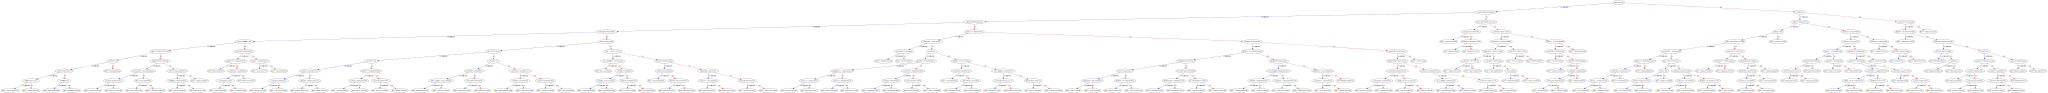

In [50]:
xgb.to_graphviz(xgb_model2)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

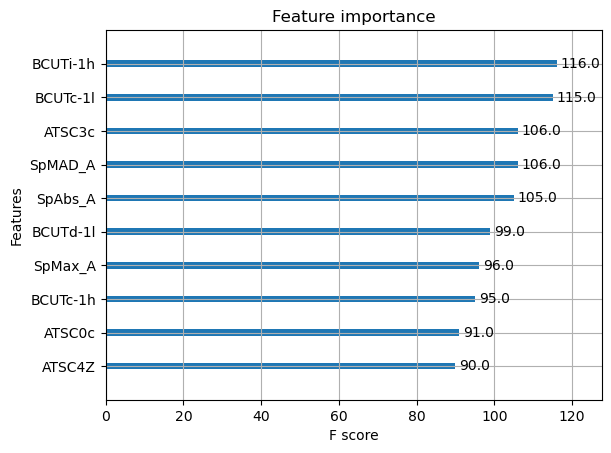

In [51]:
xgb.plot_importance(xgb_model2, max_num_features=10)